In [1]:
!pip install -U torch  ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.4/881.4 kB 9.1 MB/s eta 0:00:00


In [2]:

# import & downloading the sam weights
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qdd2h5gd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qdd2h5gd
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=0526b79bcab4df30e8f2456805c72a780e1dbf5cf352f56e104e513de0e9a648
  Stored in directory: /tmp/pip-ephem-wheel-cache-bnes2150/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-10-03 10:07:04--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 640x640 12 wears, 1536.5ms
Speed: 21.8ms preprocess, 1536.5ms inference, 42.1ms postprocess per image at shape (1, 3, 640, 640)


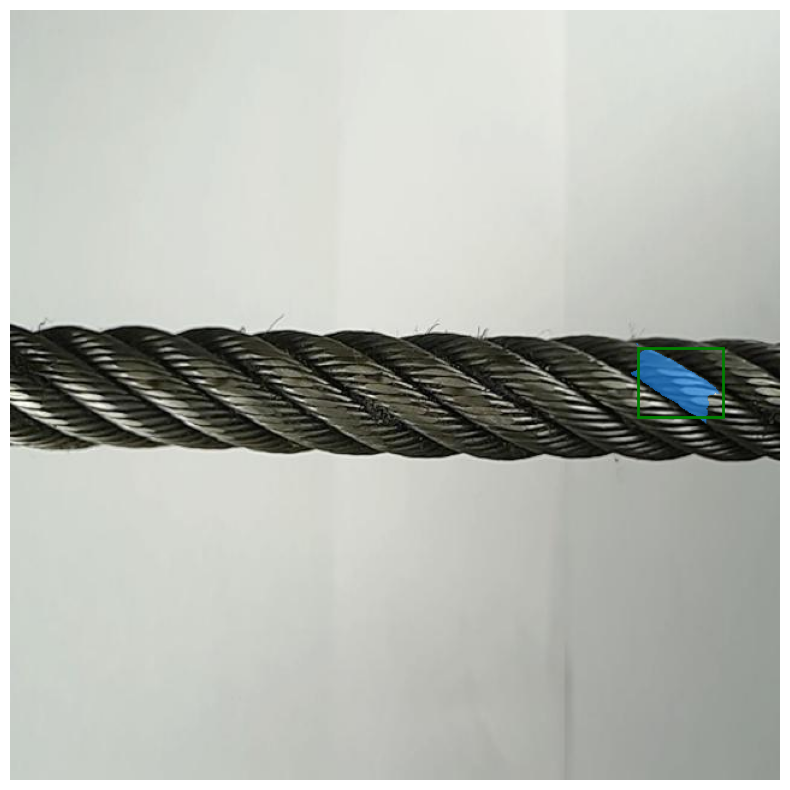

Bounding box: [516, 281, 74, 63]
Segmentation mask: [528, 281, 526, 283, 525, 283, 523, 285, 521, 285, 521, 298, 519, 300, 518, 300, 517, 301, 516, 301, 516, 302, 517, 303, 518, 303, 519, 304, 520, 304, 522, 306, 523, 306, 526, 309, 527, 309, 529, 311, 530, 311, 532, 313, 533, 313, 536, 316, 537, 316, 538, 317, 539, 317, 542, 320, 543, 320, 544, 321, 545, 321, 546, 322, 547, 322, 548, 323, 549, 323, 550, 324, 551, 324, 553, 326, 554, 326, 559, 331, 560, 331, 561, 332, 562, 332, 564, 334, 565, 334, 566, 335, 567, 335, 568, 336, 569, 336, 571, 338, 572, 338, 575, 341, 576, 341, 578, 343, 578, 337, 579, 336, 579, 332, 578, 331, 579, 330, 579, 329, 580, 328, 580, 325, 579, 324, 579, 321, 581, 319, 584, 319, 586, 317, 587, 318, 589, 318, 588, 317, 588, 316, 586, 314, 586, 313, 585, 313, 583, 311, 582, 311, 578, 307, 577, 307, 576, 306, 575, 306, 574, 305, 573, 305, 571, 303, 570, 303, 568, 301, 567, 301, 566, 300, 565, 300, 564, 299, 563, 299, 562, 298, 561, 298, 558, 295, 557, 295, 556, 29

In [3]:
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import torch
from PIL import Image
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt


def yolov8_detection(model, image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs

    bbox=boxes.xyxy.tolist()[0]
    return bbox, image

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

image_path = '/content/wear_og.jpg'
model=YOLO('/content/3000_200.pt')
yolov8_boxex, image = yolov8_detection(model, image_path)

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

input_box = np.array(yolov8_boxex)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

for i, mask in enumerate(masks):
    # Convert the mask to a binary image
    #binary_mask = mask.cpu().numpy().squeeze().astype(np.uint8)
    binary_mask = torch.from_numpy(masks).squeeze().numpy().astype(np.uint8)

    # Find the contours of the mask
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the new bounding box
    bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

    # Get the segmentation mask for object
    segmentation = largest_contour.flatten().tolist()

    # Write bounding boxes to file in YOLO format
    with open('bounding_boxe_NEW_137.txt', 'w') as f:
        for contour in contours:
            # Get the bounding box coordinates of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Convert the coordinates to YOLO format and write to file
            f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))

    mask=segmentation

    # load the image
    #width, height = image_path.size
    img = Image.open(image_path)
    width, height = img.size

    # convert mask to numpy array of shape (N,2)
    mask = np.array(mask).reshape(-1,2)

    # normalize the pixel coordinates
    mask_norm = mask / np.array([width, height])

    # compute the bounding box
    xmin, ymin = mask_norm.min(axis=0)
    xmax, ymax = mask_norm.max(axis=0)
    bbox_norm = np.array([xmin, ymin, xmax, ymax])

    # concatenate bbox and mask to obtain YOLO format
    yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

    # write the yolo values to a text file
    with open('yolo_maskformat.txt', 'w') as f:
        for val in yolo:
            f.write("{:.6f} ".format(val))

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.show()

    # Print the bounding box and segmentation mask
    print("Bounding box:", bbox)
    print("Segmentation mask:", segmentation)

In [ ]:
## multi object detection


0: 640x640 12 wears, 578.1ms
Speed: 5.0ms preprocess, 578.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Bounding box: [515, 281, 75, 63]
yolo [    0.80469     0.43906     0.92031     0.53594     0.82344     0.43906     0.81719     0.44531     0.81563     0.44375     0.81406     0.44375     0.81406     0.44531      0.8125     0.44688     0.81406     0.44844     0.81406     0.45312      0.8125     0.45469      0.8125     0.46094     0.81406      0.4625
     0.81406     0.46563     0.81094     0.46875     0.80937     0.46875     0.80781     0.47031     0.80469     0.47031     0.80625     0.47187     0.80625     0.47344     0.80937     0.47344      0.8125     0.47656     0.81406     0.47656     0.81563     0.47813     0.81719     0.47813     0.82188     0.48281
     0.82344     0.48281     0.82656     0.48594     0.82812     0.48594     0.83125     0.48906     0.83281     0.48906      0.8375     0.49375     0.83906     0.49375     0.84062     0.49531     0.84219    

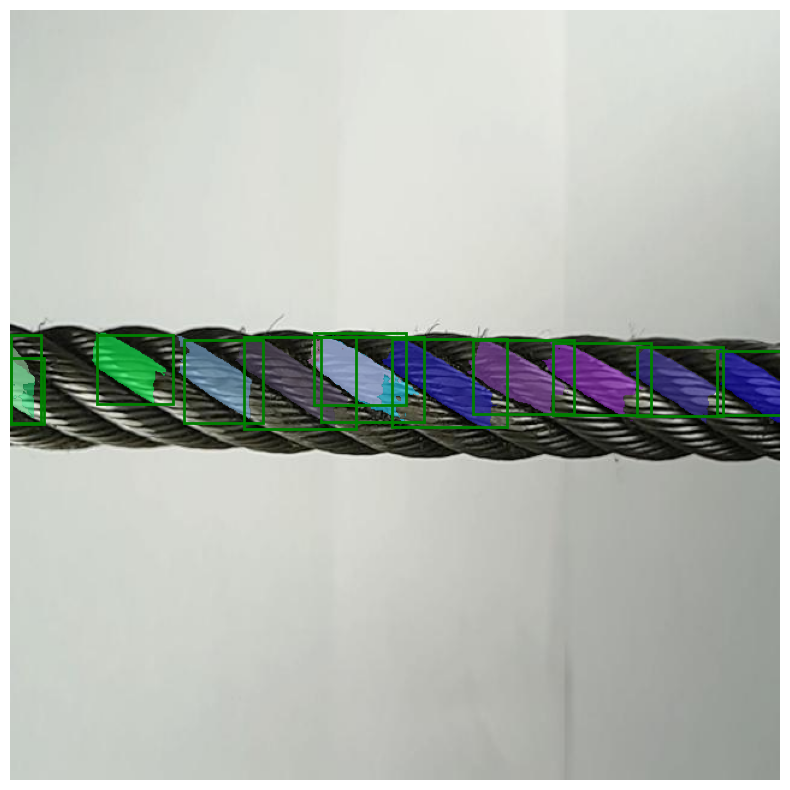

In [4]:
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import torch
from PIL import Image
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

def yolov8_detection(model, image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs

    bbox = boxes.xyxy.tolist()
    bbox = [[int(i) for i in box] for box in bbox]
    return bbox, image

image = cv2.imread('/content/wear_og.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
model=YOLO('/content/3000_200.pt')

yolov8_boxex, image = yolov8_detection(model, image_path)


sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)
input_boxes = torch.tensor(yolov8_boxex, device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

for i, mask in enumerate(masks):

    binary_mask = masks[i].squeeze().numpy().astype(np.uint8)

    # Find the contours of the mask
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    # Get the new bounding box
    bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

    # Get the segmentation mask for object
    segmentation = largest_contour.flatten().tolist()

    # Write bounding boxes to file in YOLO format
    with open('BBOX_yolo.txt', 'w') as f:
        for contour in contours:
            # Get the bounding box coordinates of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Convert the coordinates to YOLO format and write to file
            f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))
            f.write('\n')
    mask=segmentation

        # load the image
    #width, height = image_path.size
    img = Image.open(image_path)
    width, height = img.size

    # convert mask to numpy array of shape (N,2)
    mask = np.array(mask).reshape(-1,2)

    # normalize the pixel coordinates
    mask_norm = mask / np.array([width, height])

    # compute the bounding box
    xmin, ymin = mask_norm.min(axis=0)
    xmax, ymax = mask_norm.max(axis=0)
    bbox_norm = np.array([xmin, ymin, xmax, ymax])

    # concatenate bbox and mask to obtain YOLO format
    yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

    # compute the bounding box
    # write the yolo values to a text file
    with open('yolomask_format.txt', 'w') as f:
        for val in yolo:
            f.write("{:.6f} ".format(val))
        f.write('\n')

    # Print the bounding box and segmentation mask
    print("Bounding box:", bbox)
    #print("Segmentation mask:", segmentation)
    print("yolo",yolo)
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()


0: 640x640 12 wears, 966.5ms
Speed: 6.0ms preprocess, 966.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Drawing box with coords: 521, 280, 592, 337
Drawing box with coords: 451, 276, 532, 336
Drawing box with coords: 258, 271, 344, 342
Drawing box with coords: 144, 274, 210, 343
Drawing box with coords: 384, 274, 468, 335
Drawing box with coords: 317, 273, 413, 346
Drawing box with coords: 194, 271, 287, 348
Drawing box with coords: 0, 289, 28, 344
Drawing box with coords: 587, 283, 640, 336
Drawing box with coords: 252, 268, 329, 328
Drawing box with coords: 72, 270, 135, 327
Drawing box with coords: 0, 270, 25, 343


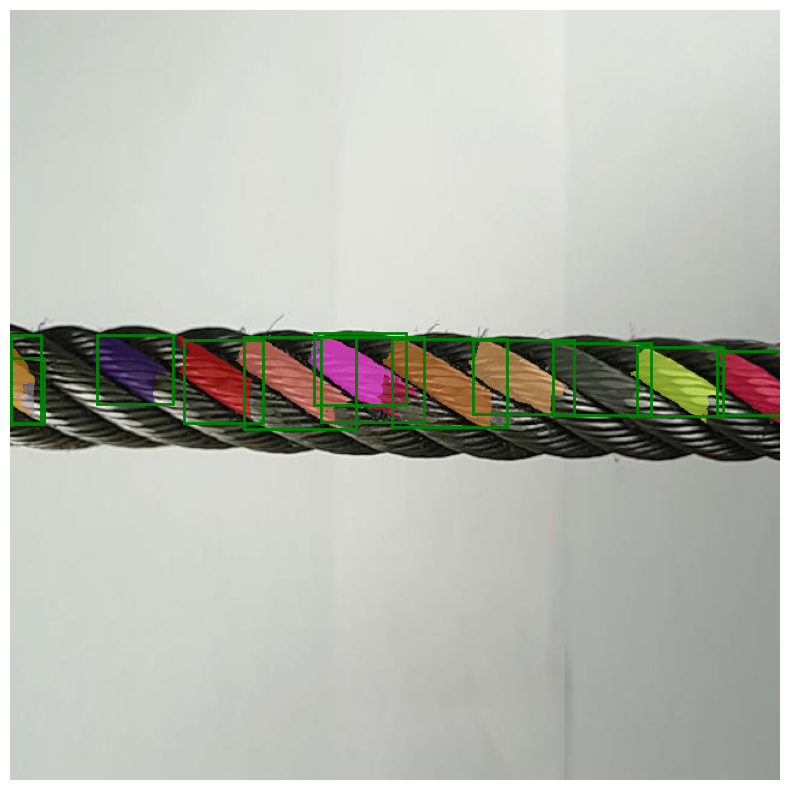

In [7]:
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import torch
from PIL import Image
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

# YOLOv8 모델을 사용해 바운딩 박스 추출
def yolov8_detection(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs

    bbox = boxes.xyxy.tolist()
    bbox = [[int(i) for i in box] for box in bbox]
    return bbox, image

# 바운딩 박스 그리기 함수
def show_box(box, ax, edge_color='green'):
    x0, y0, x1, y1 = box
    print(f"Drawing box with coords: {x0}, {y0}, {x1}, {y1}")  # 좌표를 출력해서 확인
    w, h = x1 - x0, y1 - y0
    rect = plt.Rectangle((x0, y0), w, h, edgecolor=edge_color, facecolor='none', lw=2)
    ax.add_patch(rect)

# 세그멘테이션 마스크 표시 함수
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# 이미지와 바운딩 박스, 세그멘테이션 모두 시각화
def visualize(image, input_boxes, masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)  # 이미지를 그린 후

    # 바운딩 박스 그리기 (박스를 먼저 그림)
    for box in input_boxes:
        show_box(box.cpu().numpy(), plt.gca())  # 바운딩 박스 좌표를 확인

    # 세그멘테이션 마스크 그리기 (그 위에 세그멘테이션 마스크를 그림)
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)

    plt.axis('off')
    plt.show()

# 실행 코드
image_path = '/content/wear_og.jpg'
model_path = '/content/3000_200.pt'
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

# YOLO 모델 로드 및 바운딩 박스 추출
model = YOLO(model_path)
yolov8_boxes, image = yolov8_detection(model, image_path)

# SAM 모델 설정
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

# 바운딩 박스 변환 및 세그멘테이션 예측
input_boxes = torch.tensor(yolov8_boxes, device=predictor.device)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

# 결과 시각화
visualize(image, input_boxes, masks)
